In [1]:
import torch
from torch import utils, nn, optim
from torchfsdd import TorchFSDDGenerator, TrimSilence
from torchaudio.transforms import MFCC
from torchvision.transforms import Compose

from model import DeepGRU

from tqdm.auto import tqdm
import matplotlib.pyplot as plt, numpy as np

In [2]:
# Set number of features and classes
n_mfcc = 13
n_digits = 10

In [3]:
# Specify transformations to be applied to the raw audio
transforms = Compose([
    # Trim silence from the start and end of the audio
    TrimSilence(threshold=1e-6),
    # Generate 13+1 MFCCs (and remove the first one since it is a constant offset)
    lambda audio: MFCC(sample_rate=8e3, n_mfcc=n_mfcc+1)(audio)[1:, :],
    # Standardize MFCCs for each frame
    lambda mfcc: (mfcc - mfcc.mean(axis=0)) / mfcc.std(axis=0),
    # Transpose from DxT to TxD
    lambda mfcc: mfcc.transpose(1, 0)
])

# Initialize a generator for a local version of FSDD
fsdd = TorchFSDDGenerator(version='local', path='../lib/test/data/v1.0.10/', transforms=transforms)

# Create two Torch datasets for a train-test split from the generator
train_set, val_set, test_set = fsdd.train_val_test_split(test_size=0.15, val_size=0.15)

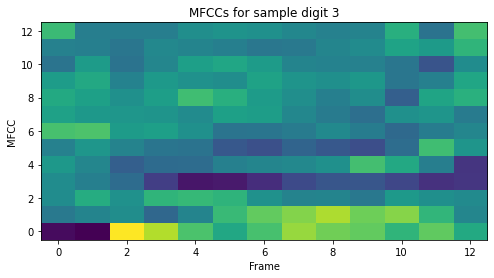

In [4]:
mfcc, digit = train_set[0]
fig, ax = plt.subplots(figsize=(8, 4))
cax = ax.imshow(np.swapaxes(mfcc, 0, 1), interpolation='nearest', cmap='viridis', origin='lower', aspect='auto')
ax.set(title='MFCCs for sample digit {}'.format(digit), xlabel='Frame', ylabel='MFCC')
plt.show()

In [5]:
def collate_fn(batch):
    """Collects together sequences into a single batch, arranged in descending length order."""
    batch_size = len(batch)

    # Sort the (sequence, label) pairs in descending order of duration
    batch.sort(key=(lambda x: len(x[0])), reverse=True)
    # Shape: list(tuple(tensor(TxD), int))

    # Create list of sequences, and tensors for lengths and labels
    sequences, lengths, labels = [], torch.zeros(batch_size, dtype=torch.long), torch.zeros(batch_size, dtype=torch.long)
    for i, (sequence, label) in enumerate(batch):
        lengths[i], labels[i] = len(sequence), label
        sequences.append(sequence)

    # Combine sequences into a padded matrix
    padded_sequences = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    # Shape: (B x T_max x D)

    return padded_sequences, lengths, labels
    # Shapes: (B x T_max x D), (B,), (B,)

In [6]:
# Create training, validation and test set batch iterators
train_gen = utils.data.DataLoader(train_set, collate_fn=collate_fn, batch_size=64, shuffle=True, num_workers=0)
val_gen = utils.data.DataLoader(val_set, collate_fn=collate_fn, batch_size=64, shuffle=True, num_workers=0)
test_gen = utils.data.DataLoader(test_set, collate_fn=collate_fn, batch_size=len(test_set), num_workers=0)

In [7]:
# Create a DeepGRU neural network model
model = DeepGRU(n_mfcc, n_digits)

# Set loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

In [8]:
for epoch in tqdm(range(3), desc='Epoch'):
    # Training loop
    model.train()
    for batch, lengths, labels in tqdm(train_gen, desc='Training batch', leave=False):
        # Reset the optimizer
        optimizer.zero_grad()
        # Calculate predictions for batch
        log_prob = model(batch, lengths)
        y_pred = torch.argmax(log_prob, dim=1)
        # Calculate and back-propagate loss
        loss = criterion(log_prob, labels)
        loss.backward()
        # Update the optimizer
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for batch, lengths, labels in tqdm(val_gen, desc='Validation batch', leave=False):
            # Calculate predictions for batch
            log_prob = model(batch, lengths)
            y_pred = torch.argmax(log_prob, dim=1)
            # Calculate loss
            loss = criterion(log_prob, labels)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Training batch:   0%|          | 0/34 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/34 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/7 [00:00<?, ?it/s]

Training batch:   0%|          | 0/34 [00:00<?, ?it/s]

Validation batch:   0%|          | 0/7 [00:00<?, ?it/s]

In [9]:
# Toggle evaluation mode
model.eval()

# Retrieve test set as a single batch
batch, lengths, labels = next(iter(test_gen))

# Calculate predictions for test set
y = model(batch, lengths)
y_pred = torch.argmax(y, dim=1)

# Calculate accuracy
torch.mean((labels == y_pred).float())

tensor(0.8548)